In [284]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

column_names = [
    'Class', 'Alcohol', 'Malicacid', 'Ash', 'Alcalinity_of_ash', 
    'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols',
    'Proanthocyanins', 'Color_intensity', 'Hue', 
    'OD280_OD315_of_diluted_wines', 'Proline'
]

df = pd.read_csv('wine.data', header=None, names=column_names)
df_selected = df.iloc[:, 1:]
print(df_selected.head())

   Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  Total_phenols  \
0    14.23       1.71  2.43               15.6        127           2.80   
1    13.20       1.78  2.14               11.2        100           2.65   
2    13.16       2.36  2.67               18.6        101           2.80   
3    14.37       1.95  2.50               16.8        113           3.85   
4    13.24       2.59  2.87               21.0        118           2.80   

   Flavanoids  Nonflavanoid_phenols  Proanthocyanins  Color_intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   OD280_OD315_of_diluted_wines  Proline  
0                        

In [285]:
print('Количество пропущенных значений:\n', df_selected.isnull().sum())

Количество пропущенных значений:
 Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
OD280_OD315_of_diluted_wines    0
Proline                         0
dtype: int64


In [286]:
print("Дескриптивный анализ:")

summary = pd.DataFrame({
    "Среднее": df_selected.mean(numeric_only=True),
    "Медиана": df_selected.median(numeric_only=True),
    "Мода": df_selected.mode().iloc[0],
    "Ст. отклонение": df_selected.std(numeric_only=True),
    "Мин": df_selected.min(),
    "Макс": df_selected.max()
})

print(summary.round(2))

Дескриптивный анализ:
                              Среднее  Медиана    Мода  Ст. отклонение  \
Alcohol                         13.00    13.05   12.37            0.81   
Malicacid                        2.34     1.87    1.73            1.12   
Ash                              2.37     2.36    2.28            0.27   
Alcalinity_of_ash               19.49    19.50   20.00            3.34   
Magnesium                       99.74    98.00   88.00           14.28   
Total_phenols                    2.30     2.36    2.20            0.63   
Flavanoids                       2.03     2.13    2.65            1.00   
Nonflavanoid_phenols             0.36     0.34    0.26            0.12   
Proanthocyanins                  1.59     1.56    1.35            0.57   
Color_intensity                  5.06     4.69    2.60            2.32   
Hue                              0.96     0.96    1.04            0.23   
OD280_OD315_of_diluted_wines     2.61     2.78    2.87            0.71   
Proline         

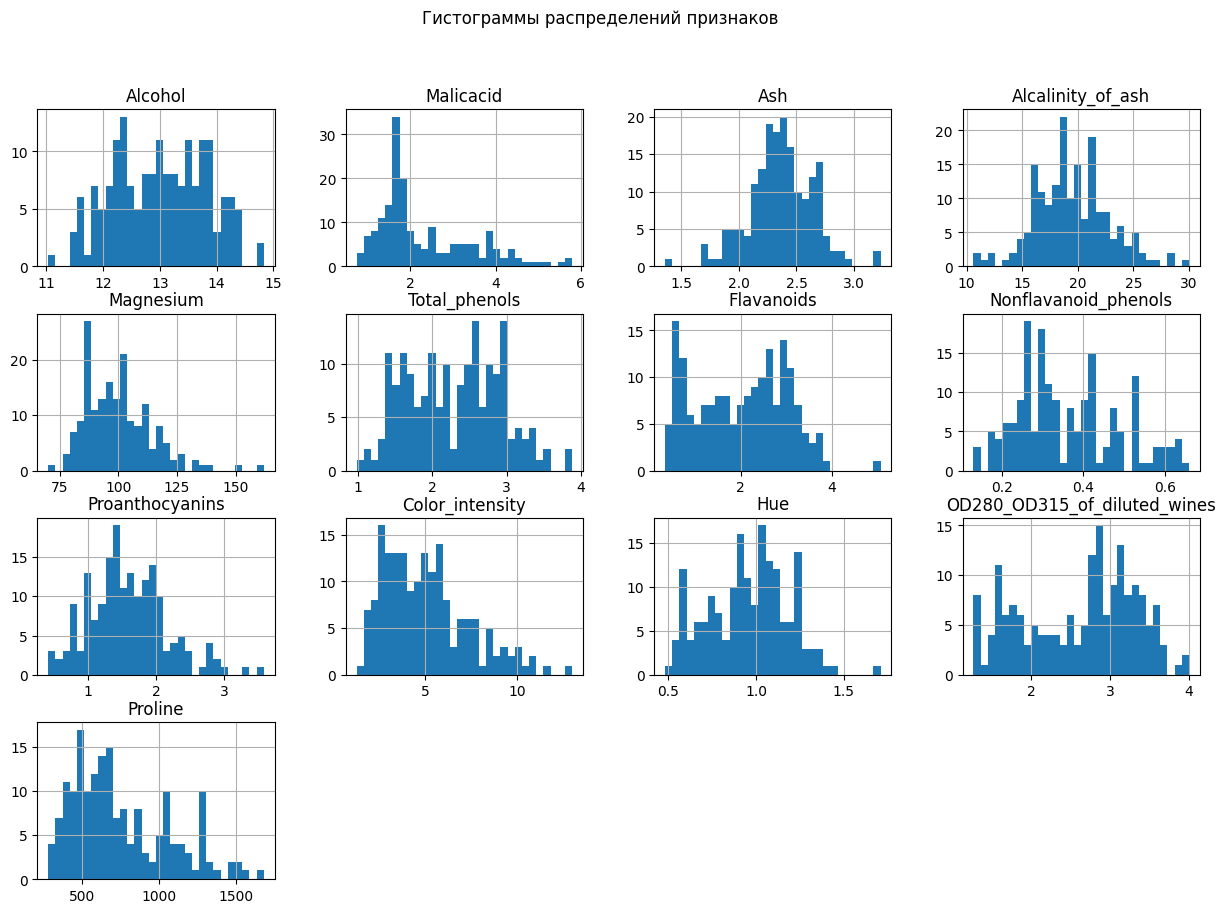

In [287]:
df_selected.hist(bins=30, figsize=(15, 10))
plt.suptitle("Гистограммы распределений признаков")
plt.show()

In [288]:
# Стандартизация данных
scaler = StandardScaler()
# fit - вычисляет среднее и стандартное отклонение каждого признака, transform — применяет формулу стандартизации
X_scaled = scaler.fit_transform(df_selected)
df_scaled = pd.DataFrame(X_scaled, columns=df_selected.columns)
print("Данные после стандартизации:")
print(df_scaled.head())

Данные после стандартизации:
    Alcohol  Malicacid       Ash  Alcalinity_of_ash  Magnesium  Total_phenols  \
0  1.518613  -0.562250  0.232053          -1.169593   1.913905       0.808997   
1  0.246290  -0.499413 -0.827996          -2.490847   0.018145       0.568648   
2  0.196879   0.021231  1.109334          -0.268738   0.088358       0.808997   
3  1.691550  -0.346811  0.487926          -0.809251   0.930918       2.491446   
4  0.295700   0.227694  1.840403           0.451946   1.281985       0.808997   

   Flavanoids  Nonflavanoid_phenols  Proanthocyanins  Color_intensity  \
0    1.034819             -0.659563         1.224884         0.251717   
1    0.733629             -0.820719        -0.544721        -0.293321   
2    1.215533             -0.498407         2.135968         0.269020   
3    1.466525             -0.981875         1.032155         1.186068   
4    0.663351              0.226796         0.401404        -0.319276   

        Hue  OD280_OD315_of_diluted_wines   P

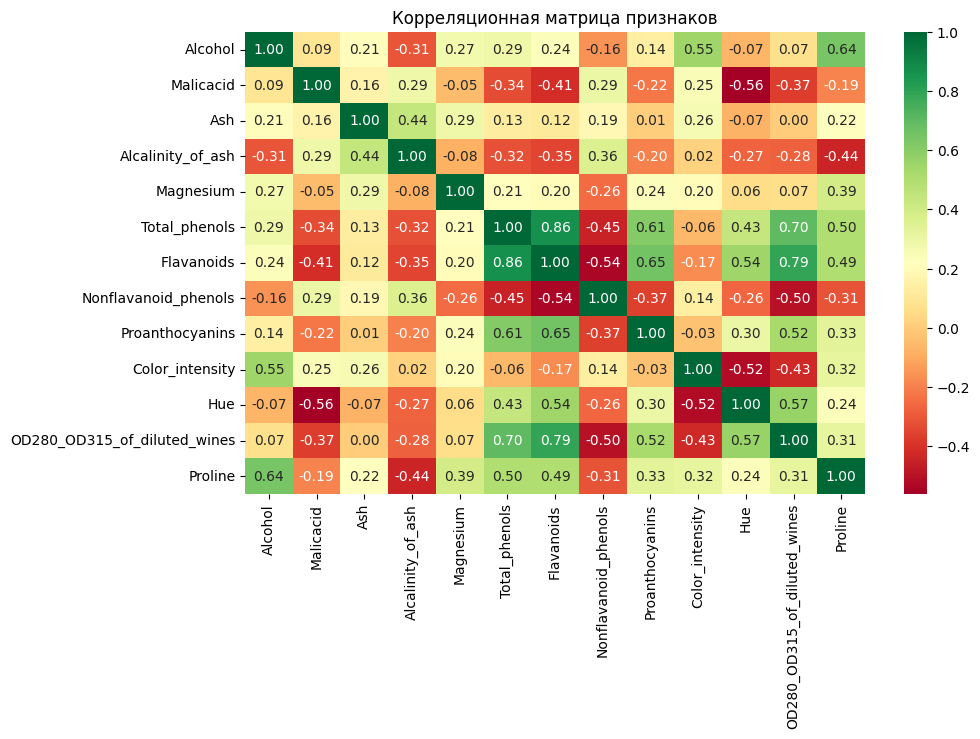

In [289]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_scaled.corr(), annot=True, cmap="RdYlGn", fmt=".2f")
plt.title("Корреляционная матрица признаков")
plt.show()

In [290]:
# Тест сферичности Бартлетта
chi_square_value, p_value = calculate_bartlett_sphericity(df_scaled)
print(f"Тест Бартлетта:")
print(f"  Chi-square: {chi_square_value:.3f}")
print(f"  p-value: {p_value:.3f}")

# KMO тест
kmo_all, kmo_model = calculate_kmo(df_scaled)
print(f"KMO тест: {kmo_model:.3f}")

Тест Бартлетта:
  Chi-square: 1317.181
  p-value: 0.000
KMO тест: 0.779


   Компонента  Доля дисперсии  Накопленная дисперсия  Собственное значение
0         PC1           0.362                  0.362                 4.732
1         PC2           0.192                  0.554                 2.511
2         PC3           0.111                  0.665                 1.454
3         PC4           0.071                  0.736                 0.924
4         PC5           0.066                  0.802                 0.858
5         PC6           0.049                  0.851                 0.645
6         PC7           0.042                  0.893                 0.554
7         PC8           0.027                  0.920                 0.350
8         PC9           0.022                  0.942                 0.291
9        PC10           0.019                  0.962                 0.252
10       PC11           0.017                  0.979                 0.227
11       PC12           0.013                  0.992                 0.170
12       PC13           0

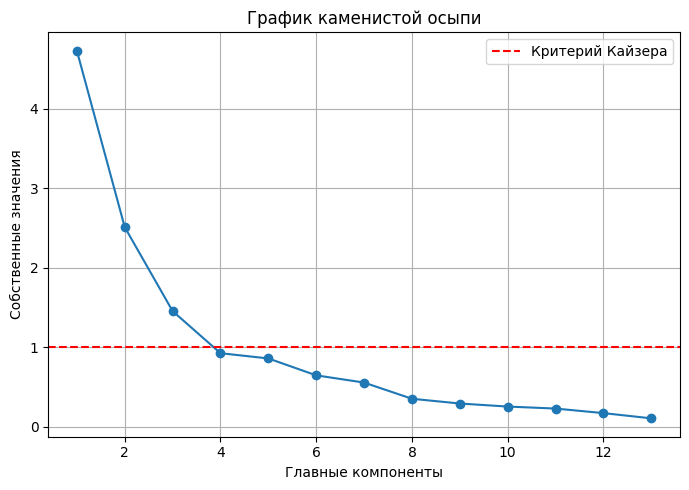

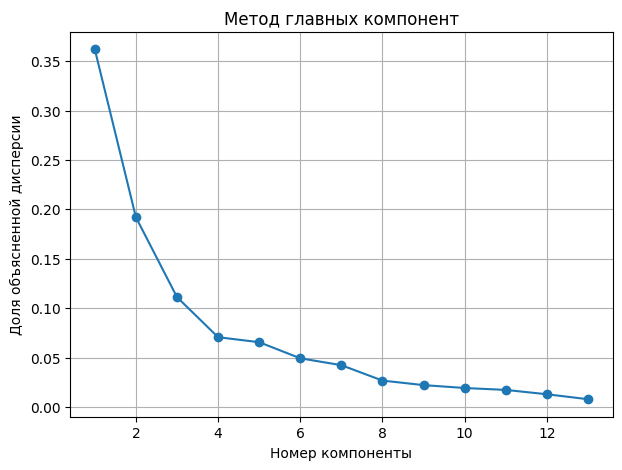

C:\Users\ПК\AppData\Local\Temp\ipykernel_7708\493108884.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


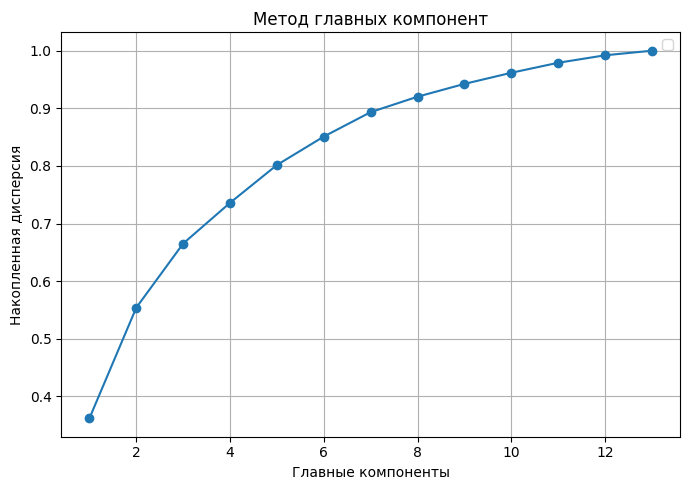

In [291]:
pca = PCA()
X_pca = pca.fit_transform(df_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
eigenvalues = pca.explained_variance_

pca_results = pd.DataFrame({
    'Компонента': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Доля дисперсии': explained_variance,
    'Накопленная дисперсия': cumulative_variance,
    'Собственное значение': eigenvalues
})

print(pca_results.round(3))

# Критерий каменистой осыпи
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-')
plt.axhline(y=1, color='r', linestyle='--', label='Критерий Кайзера')
plt.xlabel('Главные компоненты')
plt.ylabel('Собственные значения')
plt.title('График каменистой осыпи')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
pca_full = PCA().fit(df_scaled)
explained_variance_ratio = pca_full.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Номер компоненты")
plt.ylabel("Доля объясненной дисперсии")
plt.title("Метод главных компонент")
plt.grid(True)
plt.show()

# График накопленной дисперсии
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Главные компоненты')
plt.ylabel('Накопленная дисперсия')
plt.title('Метод главных компонент')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [292]:
n_factors = 5

# Факторный анализ без вращения
fa_no_rotation = FactorAnalyzer(n_factors=n_factors, rotation=None)
fa_no_rotation.fit(df_scaled)
loadings_no_rotation = fa_no_rotation.loadings_

print("Матрица нагрузок до применения вращения:")
loadings_df_no_rot = pd.DataFrame(
    loadings_no_rotation,
    index=df_scaled.columns,
    columns=[f'Factor{i+1}' for i in range(n_factors)]
)
print(loadings_df_no_rot.round(2))

Матрица нагрузок до применения вращения:
                              Factor1  Factor2  Factor3  Factor4  Factor5
Alcohol                          0.30     0.69    -0.26     0.17     0.15
Malicacid                       -0.47     0.28     0.05     0.13    -0.18
Ash                              0.01     0.52     0.74     0.12     0.20
Alcalinity_of_ash               -0.49     0.01     0.61     0.06    -0.09
Magnesium                        0.32     0.52     0.17    -0.75    -0.14
Total_phenols                    0.85     0.09     0.12     0.19    -0.14
Flavanoids                       0.94    -0.02     0.15     0.18    -0.13
Nonflavanoid_phenols            -0.58     0.04     0.15     0.11     0.21
Proanthocyanins                  0.62     0.04     0.09     0.06    -0.25
Color_intensity                 -0.18     0.76    -0.18     0.14    -0.03
Hue                              0.65    -0.44     0.13    -0.16     0.47
OD280_OD315_of_diluted_wines     0.80    -0.26     0.16     0.12    -0.

d:\Dev\ИИ\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [293]:
# Факторный анализ с Varimax вращением
fa_varimax = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
fa_varimax.fit(df_scaled)
loadings_varimax = fa_varimax.loadings_

print("\nМатрица нагрузок после Varimax вращения:")
loadings_df_varimax = pd.DataFrame(
    loadings_varimax,
    index=df_scaled.columns,
    columns=[f'Factor{i+1}' for i in range(n_factors)]
)
print(loadings_df_varimax.round(2))


Матрица нагрузок после Varimax вращения:
                              Factor1  Factor2  Factor3  Factor4  Factor5
Alcohol                          0.15     0.80    -0.12     0.01     0.08
Malicacid                       -0.27     0.02    -0.50     0.18    -0.04
Ash                              0.06     0.23    -0.04     0.89     0.14
Alcalinity_of_ash               -0.23    -0.38    -0.25     0.61    -0.03
Magnesium                        0.15     0.21     0.01     0.10     0.96
Total_phenols                    0.83     0.24     0.20     0.03     0.03
Flavanoids                       0.91     0.18     0.30     0.02     0.02
Nonflavanoid_phenols            -0.52    -0.08    -0.14     0.29    -0.20
Proanthocyanins                  0.66     0.09     0.07    -0.03     0.12
Color_intensity                 -0.16     0.61    -0.50     0.12     0.09
Hue                              0.31    -0.05     0.88    -0.03     0.01
OD280_OD315_of_diluted_wines     0.77    -0.05     0.38    -0.04    -0

d:\Dev\ИИ\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


d:\Dev\ИИ\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


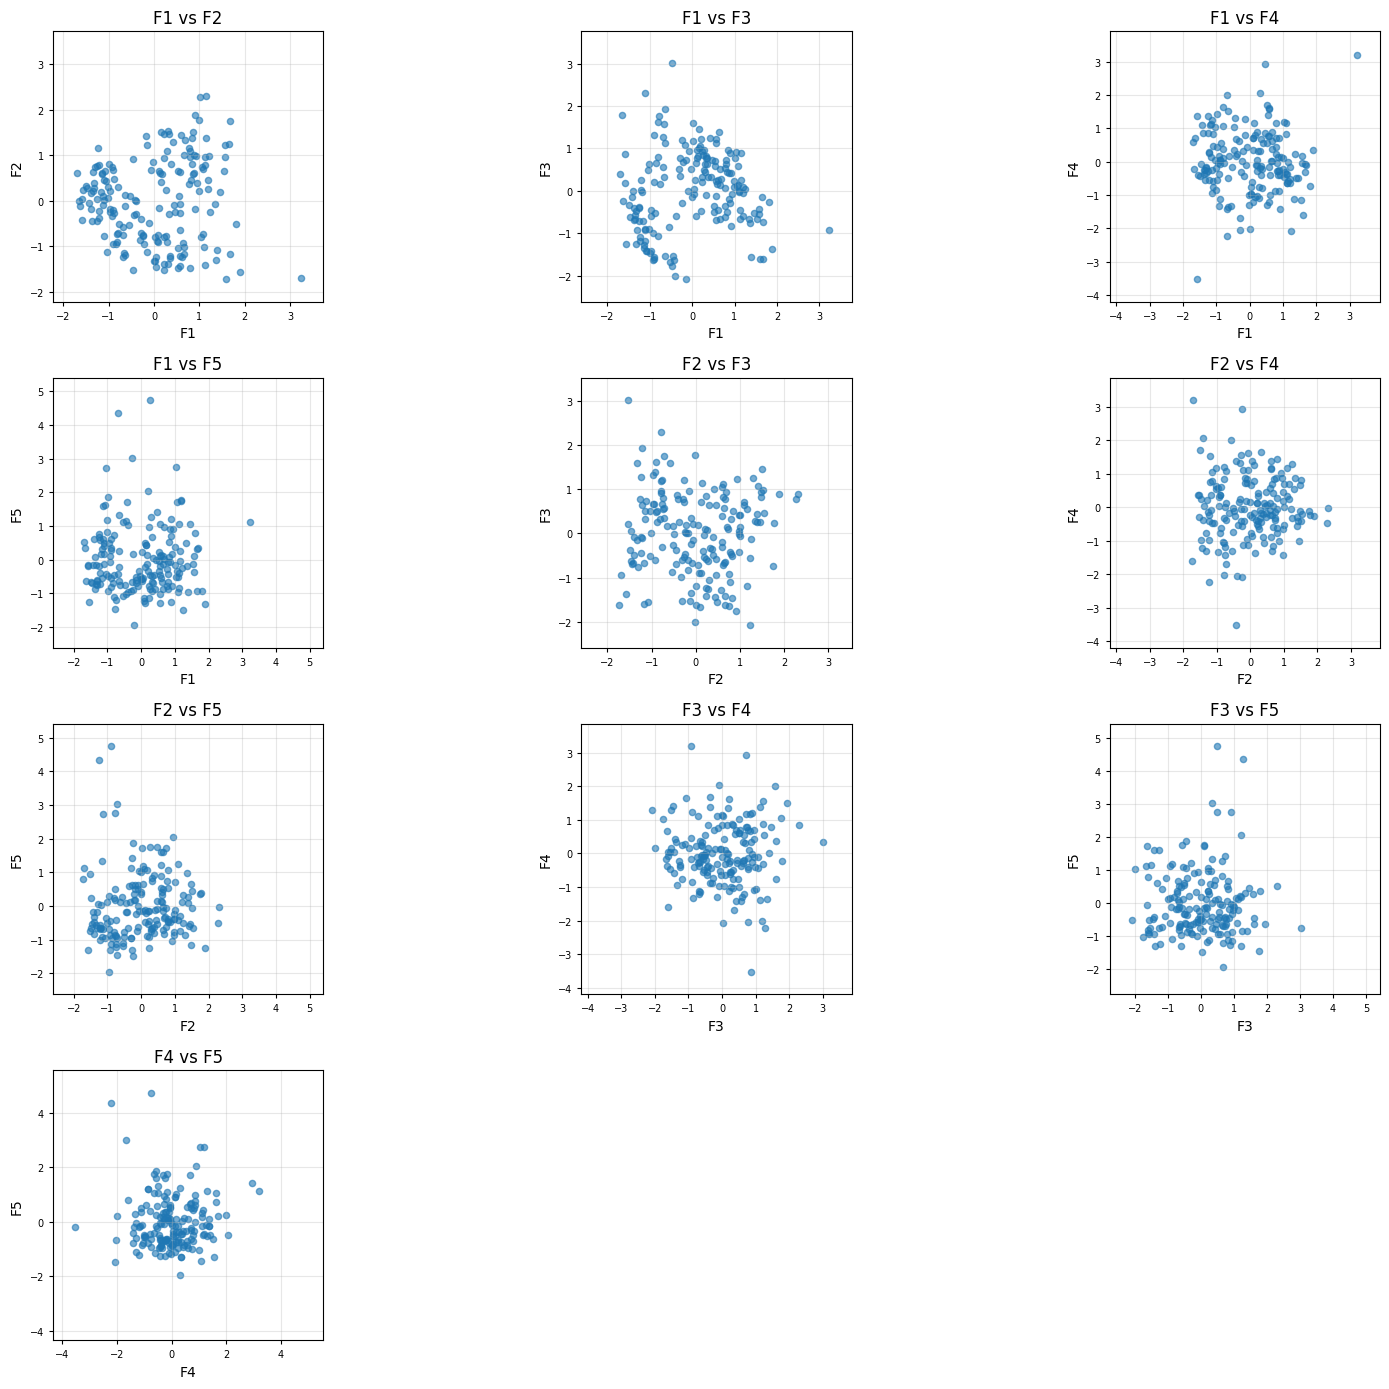

In [297]:
# Диаграммы рассеивания
factor_scores = fa_varimax.transform(df_scaled)
n_factors = factor_scores.shape[1]
n_plots = n_factors * (n_factors - 1) // 2

fig_width = min(20, 4 * (n_factors - 1))
fig_height = min(15, 3.5 * ((n_plots + 2) // 3))

plt.figure(figsize=(fig_width, fig_height))
plot_num = 1

for i in range(n_factors):
    for j in range(i + 1, n_factors):
        ax = plt.subplot((n_plots + 2) // 3, 3, plot_num)
        
        plt.scatter(factor_scores[:, i], factor_scores[:, j], alpha=0.6, s=20)
        
        x_data = factor_scores[:, i]
        y_data = factor_scores[:, j]
        
        data_min = min(x_data.min(), y_data.min())
        data_max = max(x_data.max(), y_data.max())
        margin = 0.1 * (data_max - data_min)
        plot_min = data_min - margin
        plot_max = data_max + margin
        
        plt.xlim(plot_min, plot_max)
        plt.ylim(plot_min, plot_max)
        ax.set_aspect('equal')

        plt.xlabel(f'F{i+1}')
        plt.ylabel(f'F{j+1}')
        plt.title(f'F{i+1} vs F{j+1}')
        plt.grid(True, alpha=0.3)
        
        ax.tick_params(axis='both', which='major', labelsize=7, length=3)
        
        plot_num += 1

plt.tight_layout()
plt.show()